In [ ]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

In [ ]:
#Read the csv file
df = pd.read_csv('/content/final_df.csv')
column_to_drop = 'index'
df = df.drop(column_to_drop, axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Volume,compound,negative,neutral,positive
0,2021-12-09,3613.00,3632.40,3567.00,3603.60,77990,-0.113150,0.120500,0.879500,0.000000
1,2021-12-10,3585.00,3640.85,3575.10,3636.55,78298,-0.113150,0.120500,0.879500,0.000000
2,2021-12-13,3647.00,3660.00,3603.00,3610.10,52114,-0.113150,0.120500,0.879500,0.000000
3,2021-12-14,3601.00,3634.40,3576.15,3622.80,87750,0.083467,0.080333,0.750333,0.169333
4,2021-12-15,3610.00,3622.70,3558.60,3569.60,70817,-0.113150,0.120500,0.879500,0.000000
...,...,...,...,...,...,...,...,...,...,...
492,2023-12-04,3533.05,3545.00,3499.00,3509.65,48292,-0.113150,0.120500,0.879500,0.000000
493,2023-12-05,3537.00,3537.00,3503.00,3529.90,77724,-0.113150,0.120500,0.879500,0.000000
494,2023-12-06,3530.45,3612.40,3526.90,3603.35,48863,-0.113150,0.120500,0.879500,0.000000
495,2023-12-07,3616.95,3631.00,3592.35,3616.70,37043,-0.113150,0.120500,0.879500,0.000000


<ipython-input-134-33e913a61565>:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df["Date"],y=df['Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])


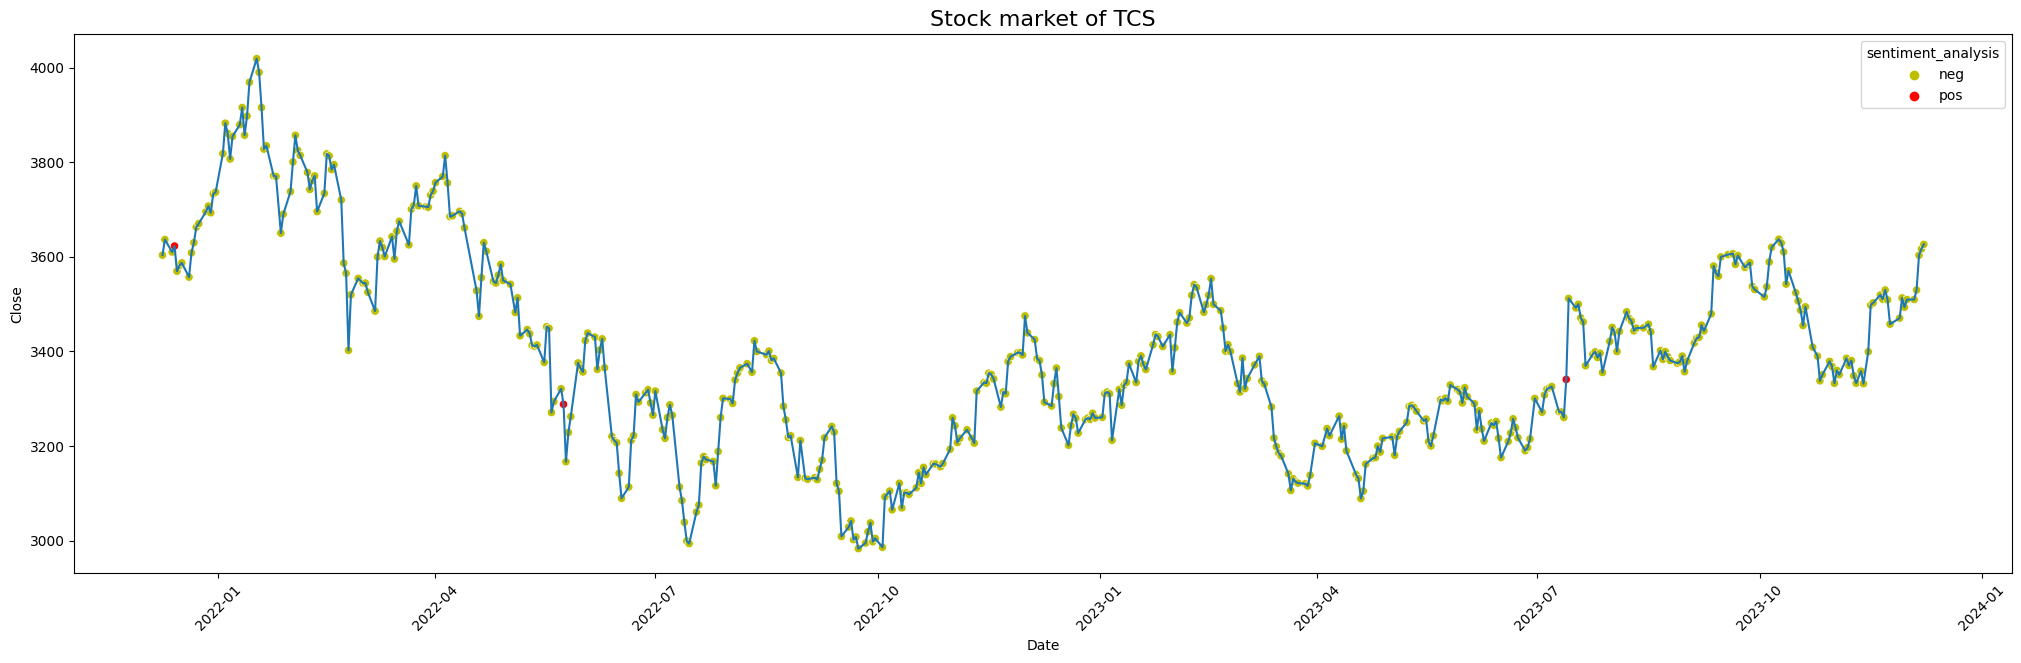

In [ ]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["Date"],y=df["Close"])
df['sentiment_analysis']=df['compound']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["Date"],y=df['Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of TCS",fontsize=16);

In [ ]:
df['sentiment_analysis'].value_counts()

neg    494
pos      3
Name: sentiment_analysis, dtype: int64

In [ ]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'index', 'compound',
       'negative', 'neutral', 'positive', 'sentiment_analysis'],
      dtype='object')


In [ ]:
train_dates = pd.to_datetime(df['Date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Volume',
    'Close',
    'compound',
        ]
print(cols)

#New dataframe
df_for_training = df[cols].astype(float)
df_for_training.index=df['Date']
df_for_training

['Open', 'High', 'Low', 'Volume', 'Close', 'compound']


,Open,High,Low,Volume,Close,compound
Date,,,,,,
2021-12-09,3613.00,3632.40,3567.00,77990.0,3603.60,-0.113150
2021-12-10,3585.00,3640.85,3575.10,78298.0,3636.55,-0.113150
2021-12-13,3647.00,3660.00,3603.00,52114.0,3610.10,-0.113150
2021-12-14,3601.00,3634.40,3576.15,87750.0,3622.80,0.083467
2021-12-15,3610.00,3622.70,3558.60,70817.0,3569.60,-0.113150
...,...,...,...,...,...,...
2023-12-04,3533.05,3545.00,3499.00,48292.0,3509.65,-0.113150
2023-12-05,3537.00,3537.00,3503.00,77724.0,3529.90,-0.113150
2023-12-06,3530.45,3612.40,3526.90,48863.0,3603.35,-0.113150


In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Close']])

df_for_training_scaled

array([[0.59484778, 0.59756454, 0.60758294, 0.0402376 , 0.59905433,
        0.        ],
       [0.56861827, 0.6057964 , 0.61526066, 0.04041517, 0.63085014,
        0.        ],
       [0.62669789, 0.62445202, 0.64170616, 0.02531937, 0.60532664,
        0.        ],
       ...,
       [0.51751756, 0.57808086, 0.56957346, 0.02344508, 0.59881309,
        0.        ],
       [0.59854801, 0.59620068, 0.63161137, 0.01663052, 0.61169545,
        0.        ],
       [0.60154567, 0.60886508, 0.63995261, 0.15344112, 0.62105568,
        0.        ]])

In [ ]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1
n_past = 5

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (492, 5, 6).
TrainY shape = (492, 1, 2).


In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_news, X_test_lstm_without_news, y_train_lstm_without_news, y_test_lstm_without_news = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_news, X_test_lstm_news, y_train_lstm_news, y_test_lstm_news = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_news.shape,X_train_lstm_news.shape

((393, 5, 5), (393, 5, 6))

In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_news, X_val_lstm_without_news, y_train_lstm_without_news, y_val_lstm_without_news = train_test_split(X_train_lstm_without_news, y_train_lstm_without_news, test_size=0.1, shuffle=False)

X_train_lstm_news, X_val_lstm_news, y_train_lstm_news, y_val_lstm_news = train_test_split(X_train_lstm_news, y_train_lstm_news, test_size=0.1, shuffle=False)

X_train_lstm_without_news.shape,X_train_lstm_news.shape

((353, 5, 5), (353, 5, 6))

In [ ]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))


    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))


    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [ ]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!python -m tensorflow.python.framework.register_op --gen_api=v2 cudnn_rnnv2

2023-12-14 04:40:36.076565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 04:40:36.076619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 04:40:36.076661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 04:40:37.603171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/bin/python3: No module named tensorflow.python.framework.register_op


In [ ]:
# fit the model

cnn_lstm_model_without_news=build_model((X_train_lstm_without_news.shape[1],X_train_lstm_without_news.shape[2]))
cnn_lstm_model_news=build_model((X_train_lstm_news.shape[1],X_train_lstm_news.shape[2]))

history_without_news = cnn_lstm_model_without_news.fit(X_train_lstm_without_news, y_train_lstm_without_news, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_news, y_val_lstm_without_news), verbose=1, )


history_news = cnn_lstm_model_news.fit(X_train_lstm_news, y_train_lstm_news, epochs=50, batch_size=64, validation_data=(X_val_lstm_news, y_val_lstm_news), verbose=1, )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 4, 128)            1408      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 2, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_8 (Bidirecti  (None, 1, 512)            659456    
 onal)                                                           
                                                      

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,news,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if news :
            plt.title(f'LSTM {type} prediction of {predicted_feature} with news sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} without news sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [ ]:
training_dates= df_for_training.index[:X_train_lstm_without_news.shape[0]]
#Make prediction
training_prediction_without_news = cnn_lstm_model_without_news.predict(X_train_lstm_without_news)

training_prediction_news = cnn_lstm_model_news.predict(X_train_lstm_news)

training_prediction_without_news=training_prediction_without_news.reshape(training_prediction_without_news.shape[0], training_prediction_without_news.shape[2])

training_prediction_news=training_prediction_news.reshape(training_prediction_news.shape[0], training_prediction_news.shape[2])

y_train_pred_lstm_without_news = scaler_for_inference.inverse_transform(training_prediction_without_news)

y_train_pred_lstm_news = scaler_for_inference.inverse_transform(training_prediction_news)

y_train_lstm_reshaped_without_news=y_train_lstm_without_news.reshape(y_train_lstm_without_news.shape[0], y_train_lstm_without_news.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_news)


12/12 [==============================] - 1s 4ms/step


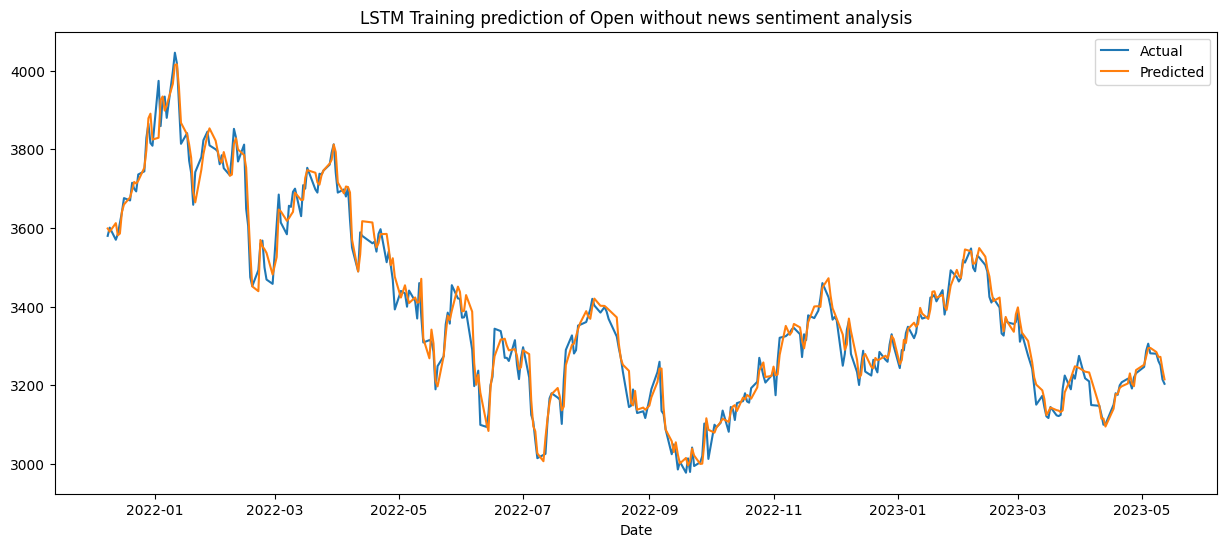

Mean square error for Open =1037.6610344555622


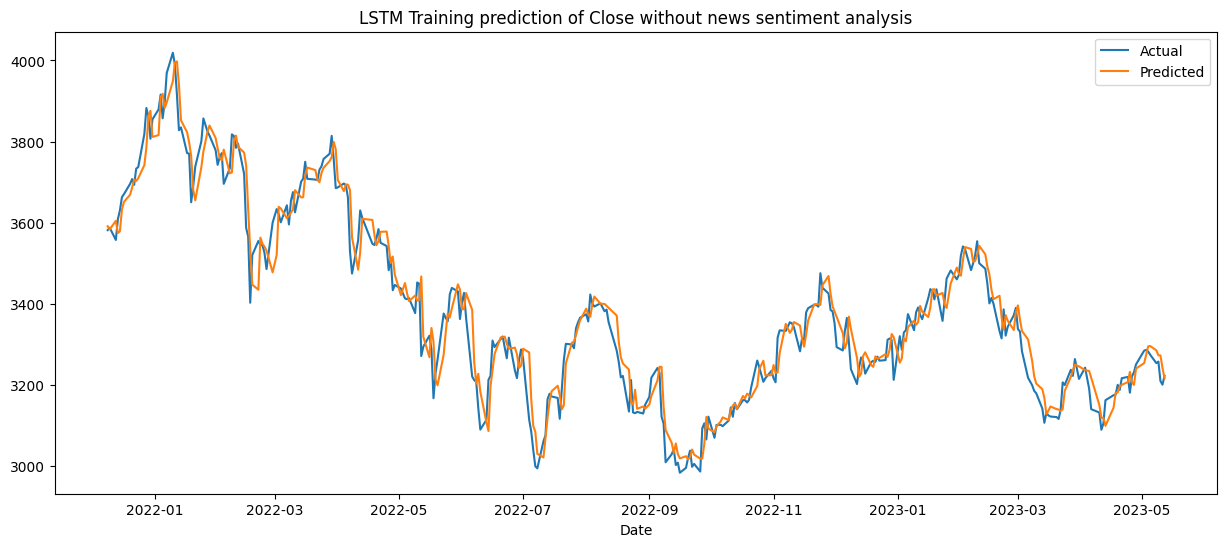

Mean square error for Close =2501.3771561150634
Total mean square error 1769.5190952853118


In [ ]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_news)

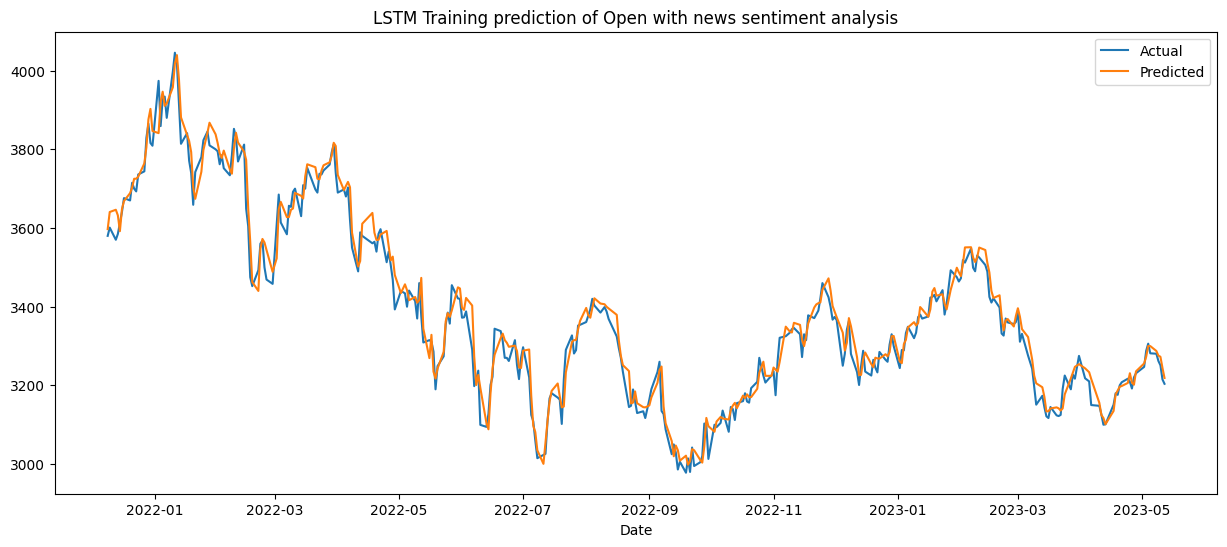

Mean square error for Open =1310.7400666709452


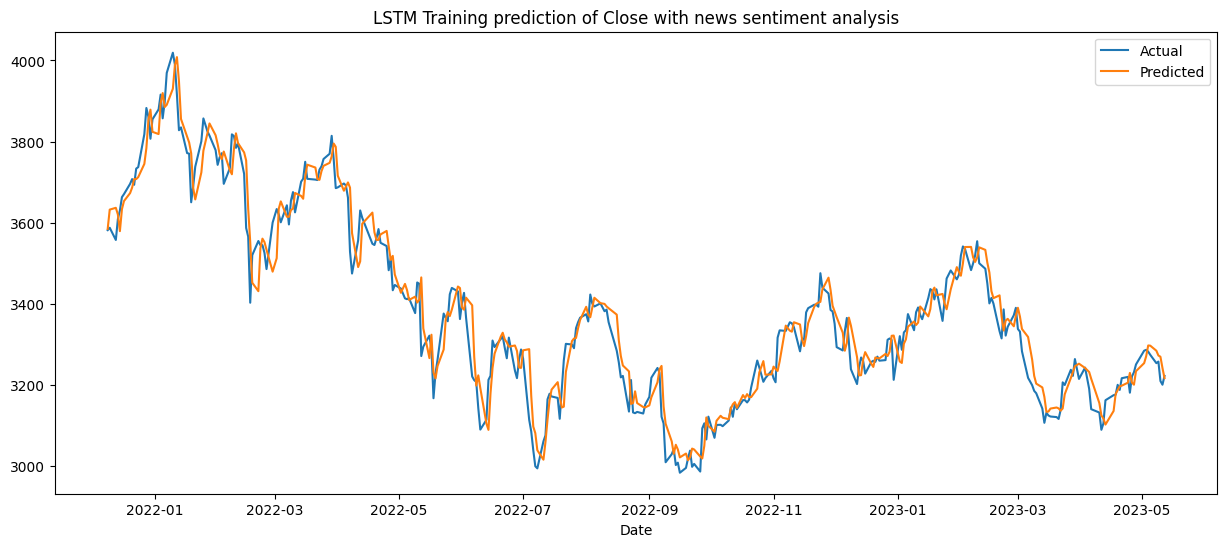

Mean square error for Close =2661.4912710026833
Total mean square error 1986.115668836815


In [ ]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_news)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Mean Squared Error of the models
mse_without_news = mean_squared_error(y_train_actual_lstm, y_train_pred_lstm_without_news)
mse_news = mean_squared_error(y_train_actual_lstm, y_train_pred_lstm_news)

print(f"MSE Without News: {mse_news}")
print(f"MSE With News: {mse_without_news}")

# Mean Absolute Error of the models
mae_without_news = mean_absolute_error(y_train_actual_lstm, y_train_pred_lstm_without_news)
mae_news = mean_absolute_error(y_train_actual_lstm, y_train_pred_lstm_news)

print(f"MAE Without News: {mae_news}")
print(f"MAE With News: {mae_without_news}")


#Root Mean Square Error of the models
rmse_without_news = np.sqrt(mean_squared_error(y_train_actual_lstm, y_train_pred_lstm_without_news))
rmse_with_news = np.sqrt(mean_squared_error(y_train_actual_lstm, y_train_pred_lstm_news))

print(f"RMSE Without News: {rmse_with_news}")
print(f"RMSE With News: {rmse_without_news}")

# R-squared for the models
r2_without_news = r2_score(y_train_actual_lstm, y_train_pred_lstm_without_news)
r2_with_news = r2_score(y_train_actual_lstm, y_train_pred_lstm_news)

print(f"R-squared without news: {r2_with_news}")
print(f"R-squared with news: {r2_without_news}")



MSE Without News: 1986.115668836815
MSE With News: 1769.5190952853118
MAE Without News: 33.92893322304357
MAE With News: 31.406628106741323
RMSE Without News: 44.56585765849026
RMSE With News: 42.065652203256185
R-squared without news: 0.9629308788965243
R-squared with news: 0.9669504737109818


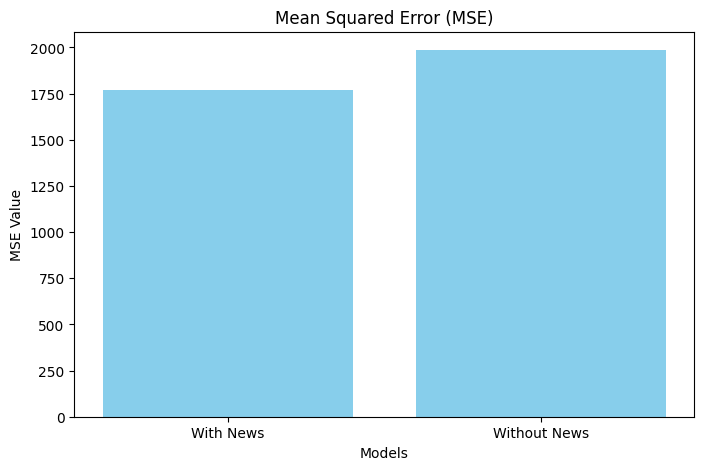

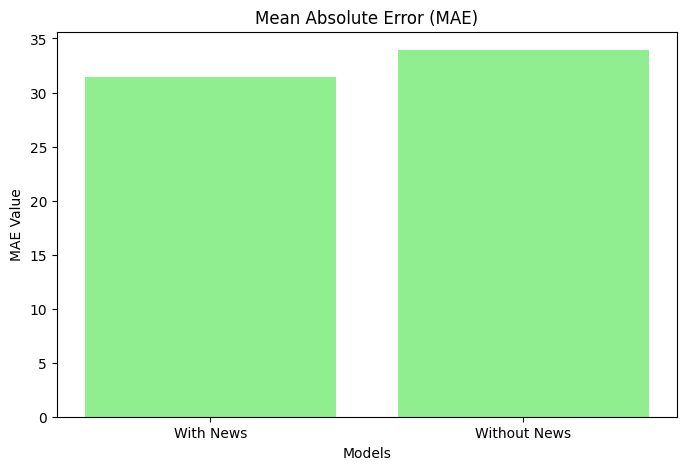

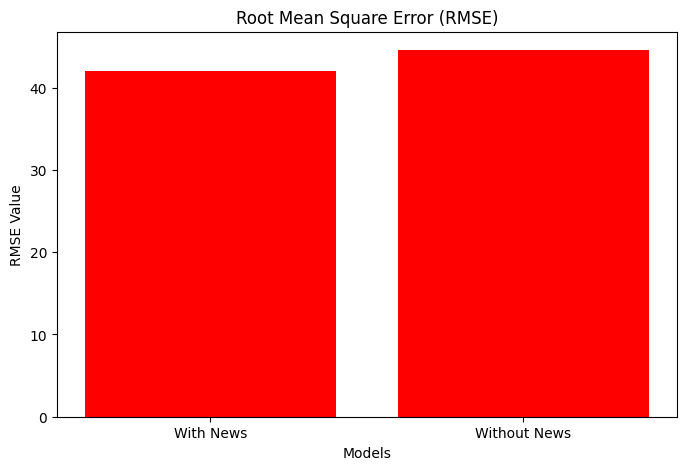

In [ ]:
import matplotlib.pyplot as plt

mse_values = [mse_without_news, mse_news]
mae_values = [mae_without_news, mae_news]
rmse_values = [rmse_without_news, rmse_with_news]


labels = ['With News', 'Without News']

# MSE
plt.figure(figsize=(8, 5))
plt.bar(labels, mse_values, color='skyblue')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Models')
plt.ylabel('MSE Value')
plt.show()

#MAE
plt.figure(figsize=(8, 5))
plt.bar(labels, mae_values, color='lightgreen')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Models')
plt.ylabel('MAE Value')
plt.show()


#RMSE
plt.figure(figsize=(8, 5))
plt.bar(labels, rmse_values, color='red')
plt.title('Root Mean Square Error (RMSE)')
plt.xlabel('Models')
plt.ylabel('RMSE Value')
plt.show()


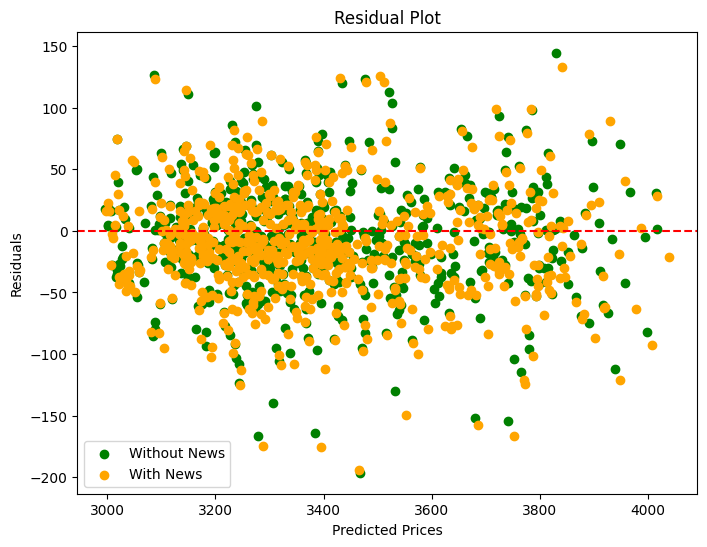

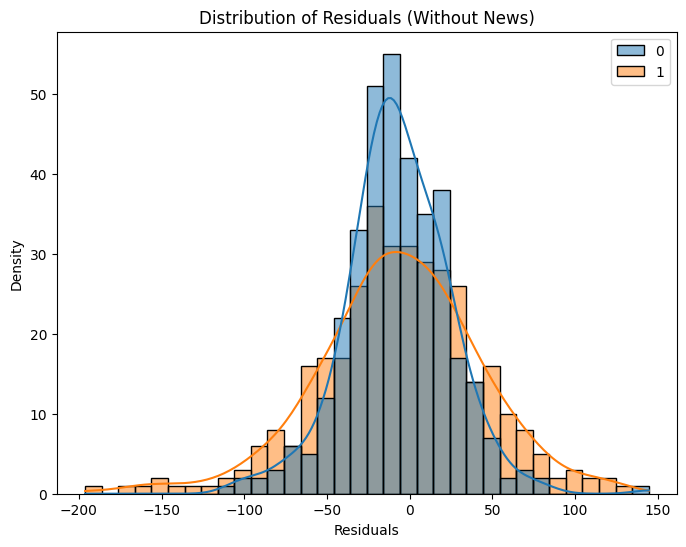

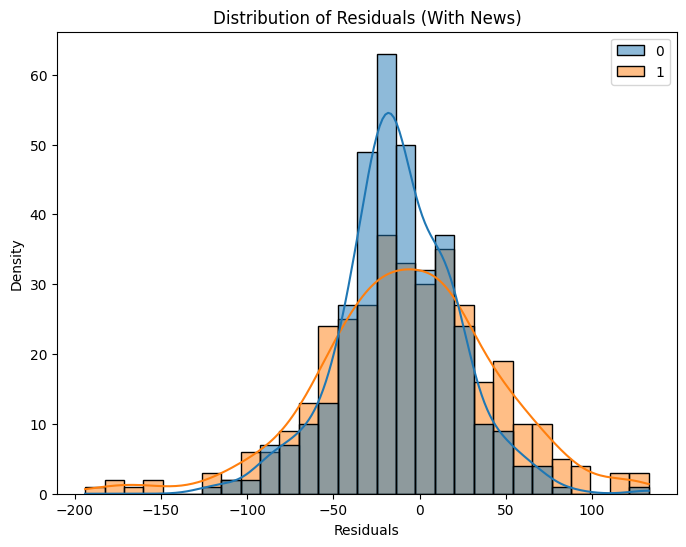

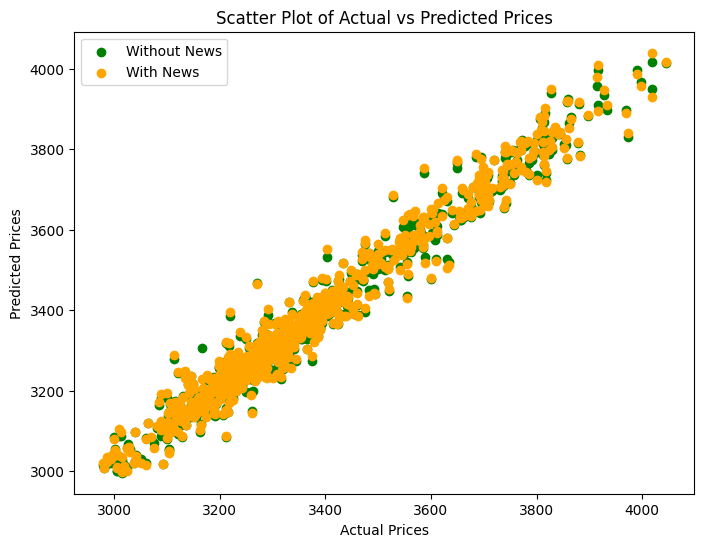

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the residuals
residuals_without_news = y_train_actual_lstm - y_train_pred_lstm_without_news
residuals_with_news = y_train_actual_lstm - y_train_pred_lstm_news

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred_lstm_without_news, residuals_without_news, label='Without News', color='green')
plt.scatter(y_train_pred_lstm_news, residuals_with_news, label='With News', color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Calculate the residuals
residuals_without_news = y_train_actual_lstm - y_train_pred_lstm_without_news
residuals_with_news = y_train_actual_lstm - y_train_pred_lstm_news

# Distribution of Residuals - Without News
plt.figure(figsize=(8, 6))
sns.histplot(residuals_without_news, kde=True, color='green')
plt.title('Distribution of Residuals (Without News)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Distribution of Residuals - With News
plt.figure(figsize=(8, 6))
sns.histplot(residuals_with_news, kde=True, color='orange')
plt.title('Distribution of Residuals (With News)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train_actual_lstm, y_train_pred_lstm_without_news, label='Without News', color='green')
plt.scatter(y_train_actual_lstm, y_train_pred_lstm_news, label='With News', color='orange')
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()


In [ ]:
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import AbstractHolidayCalendar, nearest_workday, Holiday

# holiday calendar
class IndianHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('Diwali', month=11, day=4),
        Holiday('Republic Day', month=1, day=26),
        Holiday('Independence Day', month=8, day=15),
        Holiday('Vaisakhi', month=4, day=13),
        Holiday('Makar Sankranti', month=1, day=14),
        Holiday('Gandhi Jayanti', month=10, day=2),


    ]

indian_bd = CustomBusinessDay(calendar=IndianHolidays())

# Define the number of past dates and days for prediction
n_past_dates = 5
n_days_for_prediction = 5

# Get the prediction period dates based on Indian business days
predict_period_dates_indian = pd.date_range(list(df_for_training.index)[-n_past_dates], periods=n_days_for_prediction,
                                            freq=indian_bd).tolist()

print(predict_period_dates_indian)

[Timestamp('2023-12-04 00:00:00', freq='C'), Timestamp('2023-12-05 00:00:00', freq='C'), Timestamp('2023-12-06 00:00:00', freq='C'), Timestamp('2023-12-07 00:00:00', freq='C'), Timestamp('2023-12-08 00:00:00', freq='C')]


In [ ]:
features= ['Open ','High ', 'Low ','Close ','Volume','compound']
df_for_training.iloc[-n_past:,:].to_numpy().reshape(1,n_past,len(features)).shape


(1, 5, 6)

In [ ]:
x_forcast=df_for_training.iloc[-n_past-1:-1,:]
x_forcast=scaler.transform(x_forcast).reshape(1,n_past,len(features))
prediction = cnn_lstm_model_news.predict(x_forcast) #shape = (n, 1) where n is the n_days_for_prediction
prediction=prediction.reshape(prediction.shape[0],prediction.shape[2])
#Perform inverse transformation to rescale back to original range
prediction=scaler_for_inference.inverse_transform(prediction)

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates_indian:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {prediction[0][0]}')
print(f'Date = {forecast_dates[-2]}, Prediction close {prediction[0][1]}')

1/1 [==============================] - 0s 19ms/step
Date = 2023-12-07, Prediction open 3638.637939453125
Date = 2023-12-07, Prediction close 3625.081787109375




1.   Date = 2023-12-07, Actual open 3,616.95
2.   Date = 2023-12-07, Actual close 3,617.70

